In [1]:
# import packages and declare settings

import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import anndata
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize']=(7,7)
sc.set_figure_params(dpi=150, dpi_save=300)
sc.settings.verbosity = 0
sc.logging.print_versions()


-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                 9.5.0
asttokens           NA
backcall            0.2.0
cffi                1.15.1
colorama            0.4.6
comm                0.1.3
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
defusedxml          0.7.1
executing           1.2.0
gmpy2               2.1.2
h5py                3.8.0
igraph              0.10.4
importlib_resources NA
ipykernel           6.23.1
ipython_genutils    0.2.0
jedi                0.18.2
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.1
llvmlite            0.40.0
louvain             0.8.0
matplotlib          3.7.1
matplotlib_inline   0.1.6
mpl_toolkits        NA
mpmath              1.3.0
natsort             8.3.1
numba               0.57.0
numpy               1.24.3
opt_einsum          v3.3.0
packaging           23.1
pandas              2.0.2
parso               0.8.3
pexpect             

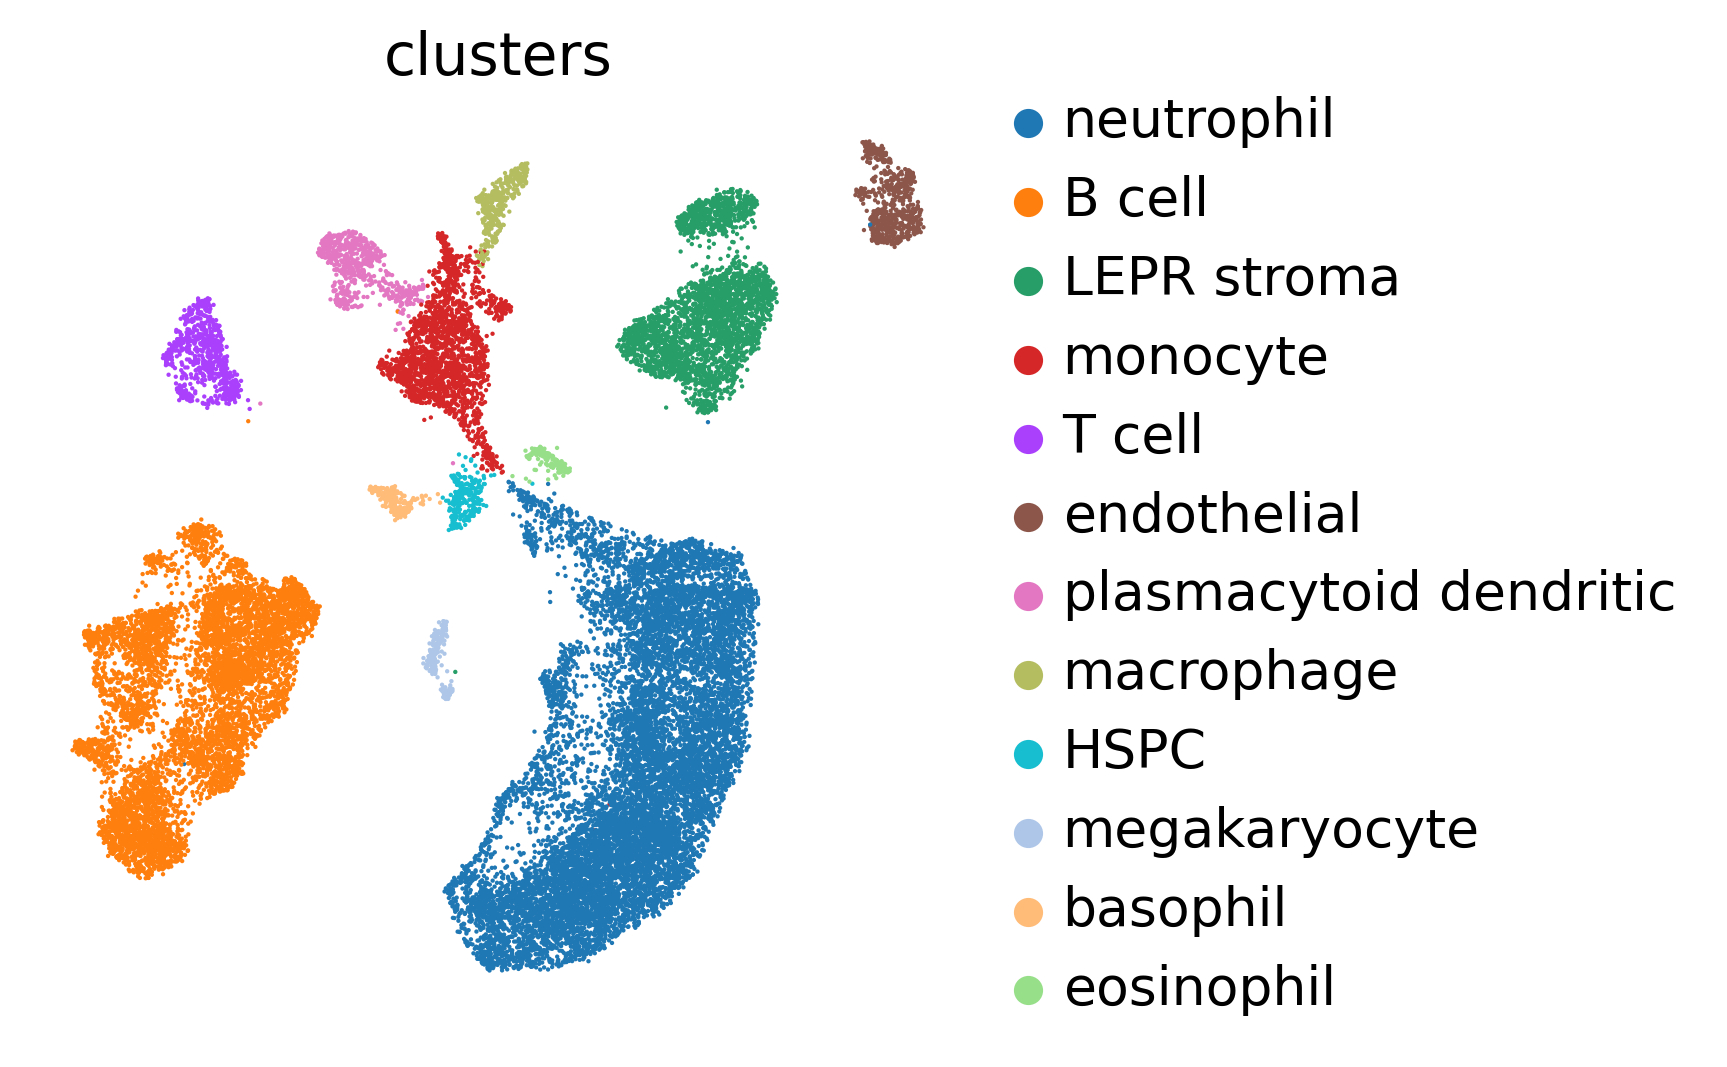

AnnData object with n_obs × n_vars = 27555 × 13806
    obs: 'sample', 'n_counts', 'log_counts', 'n_genes', 'log_genes', 'mt_frac', 'percent_ribo', 'doublet_score_solo', 'singlet_score_solo', 'doublet_singlet_solo', 'clusters', 'scran_size_factors'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'clusters2_colors', 'clusters3_colors', 'clusters_colors', 'leiden', 'log1p', 'neighbors', 'sample_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'SCRAN', 'denoised', 'scVI_latent'
    obsp: 'connectivities', 'distances'

In [2]:
# import adata file

adata = anndata.read('/data/user/sfortma2/scranPY_tutorial.h5ad')
sc.pl.umap(adata, color=['clusters'], frameon=False)
adata


In [3]:
# scranPY requires raw counts (i.e. not normalized and not log-transformed) in the active adata.X slot
# therefore, we set adata.X to raw denoised counts

adata.X = adata.layers['denoised'].copy()


Current smallest cluster =  151  cells.
Using max_size =  3000 , clusters have been split into  18  clusters.
min_mean =  0.1
--- 10.88 mins ---
size factor min =  0.04636896023358685
size factor max =  8.977288111278305
Saved plots to: /data/user/sfortma2/scranPY_normalization.pdf


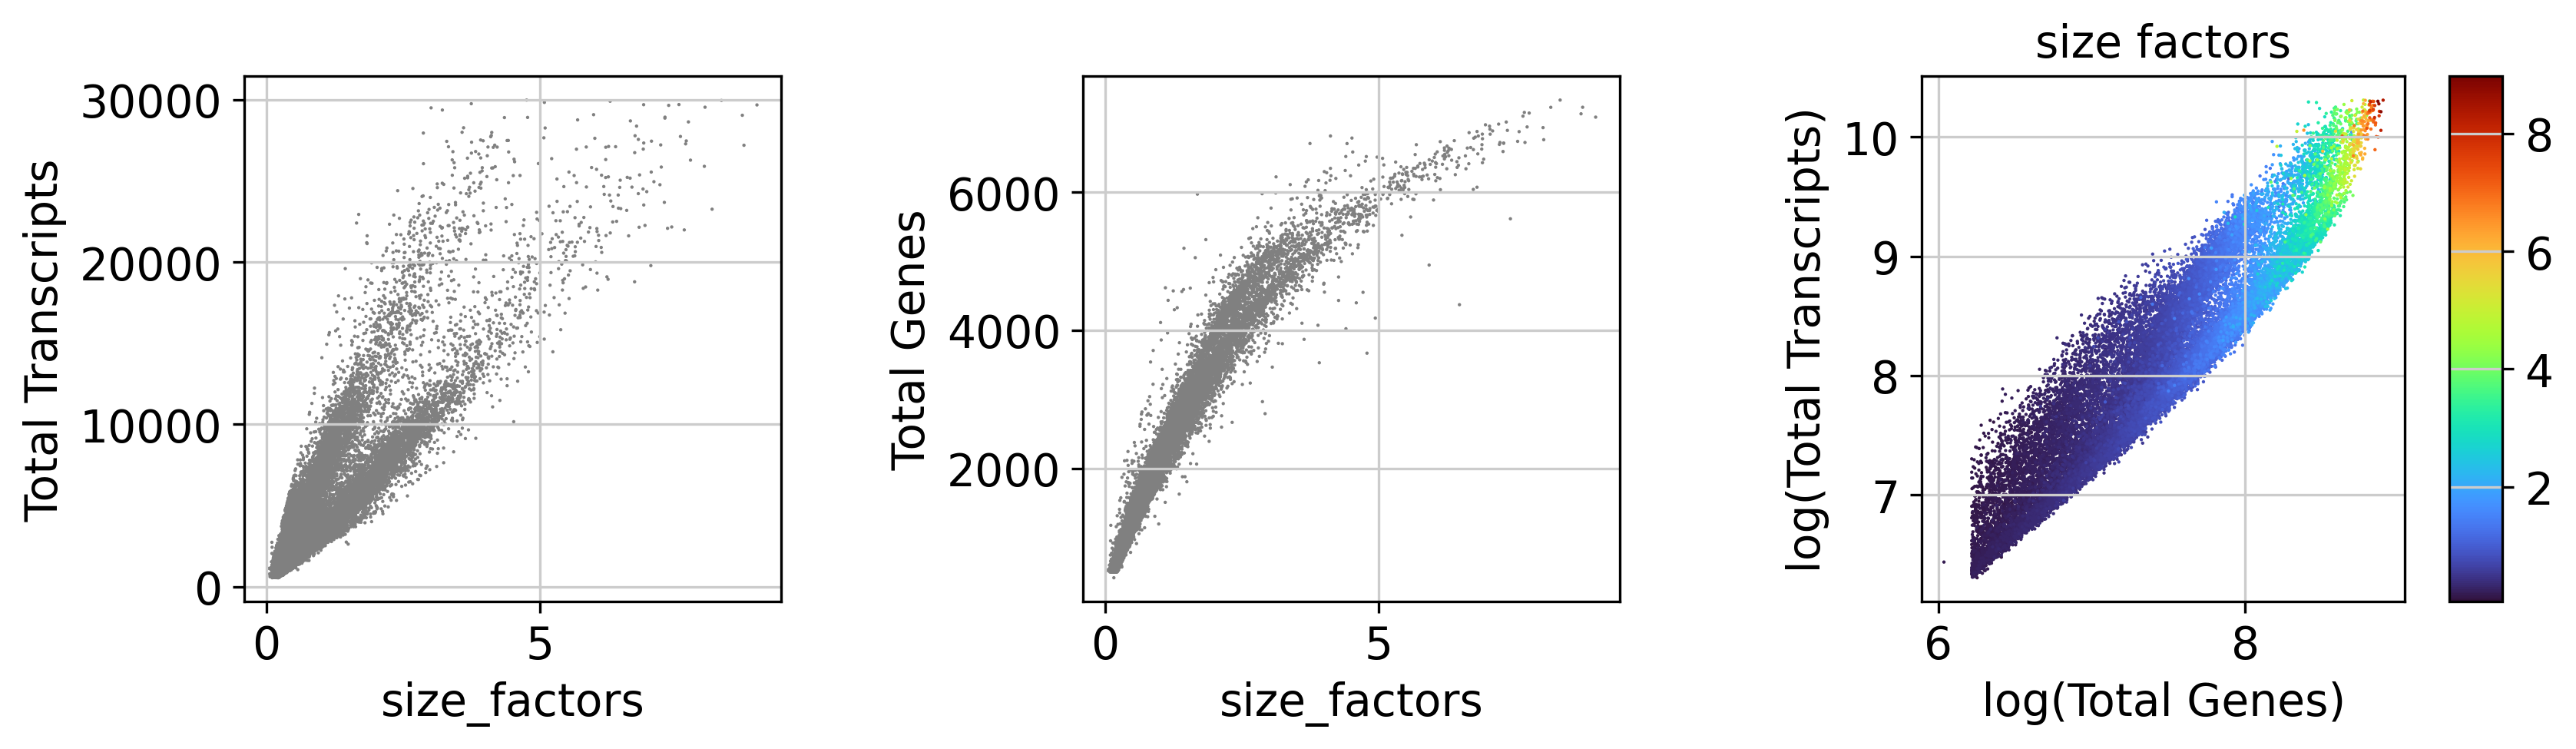

array([3.75591646, 2.46786368, 0.73667683, ..., 0.36308371, 0.29638635,
       1.86778935])

<Figure size 600x600 with 0 Axes>

In [4]:
# perform scranPY normalization

import scranPY
scranPY.compute_sum_factors(adata, clusters='clusters', parallelize=True, algorithm='CVXPY', max_size=3000, plotting=True,
    lower_bound=0.4, normalize_counts=False, log1p=False, layer=None, verbose=False, save_plots_dir='/data/user/sfortma2')


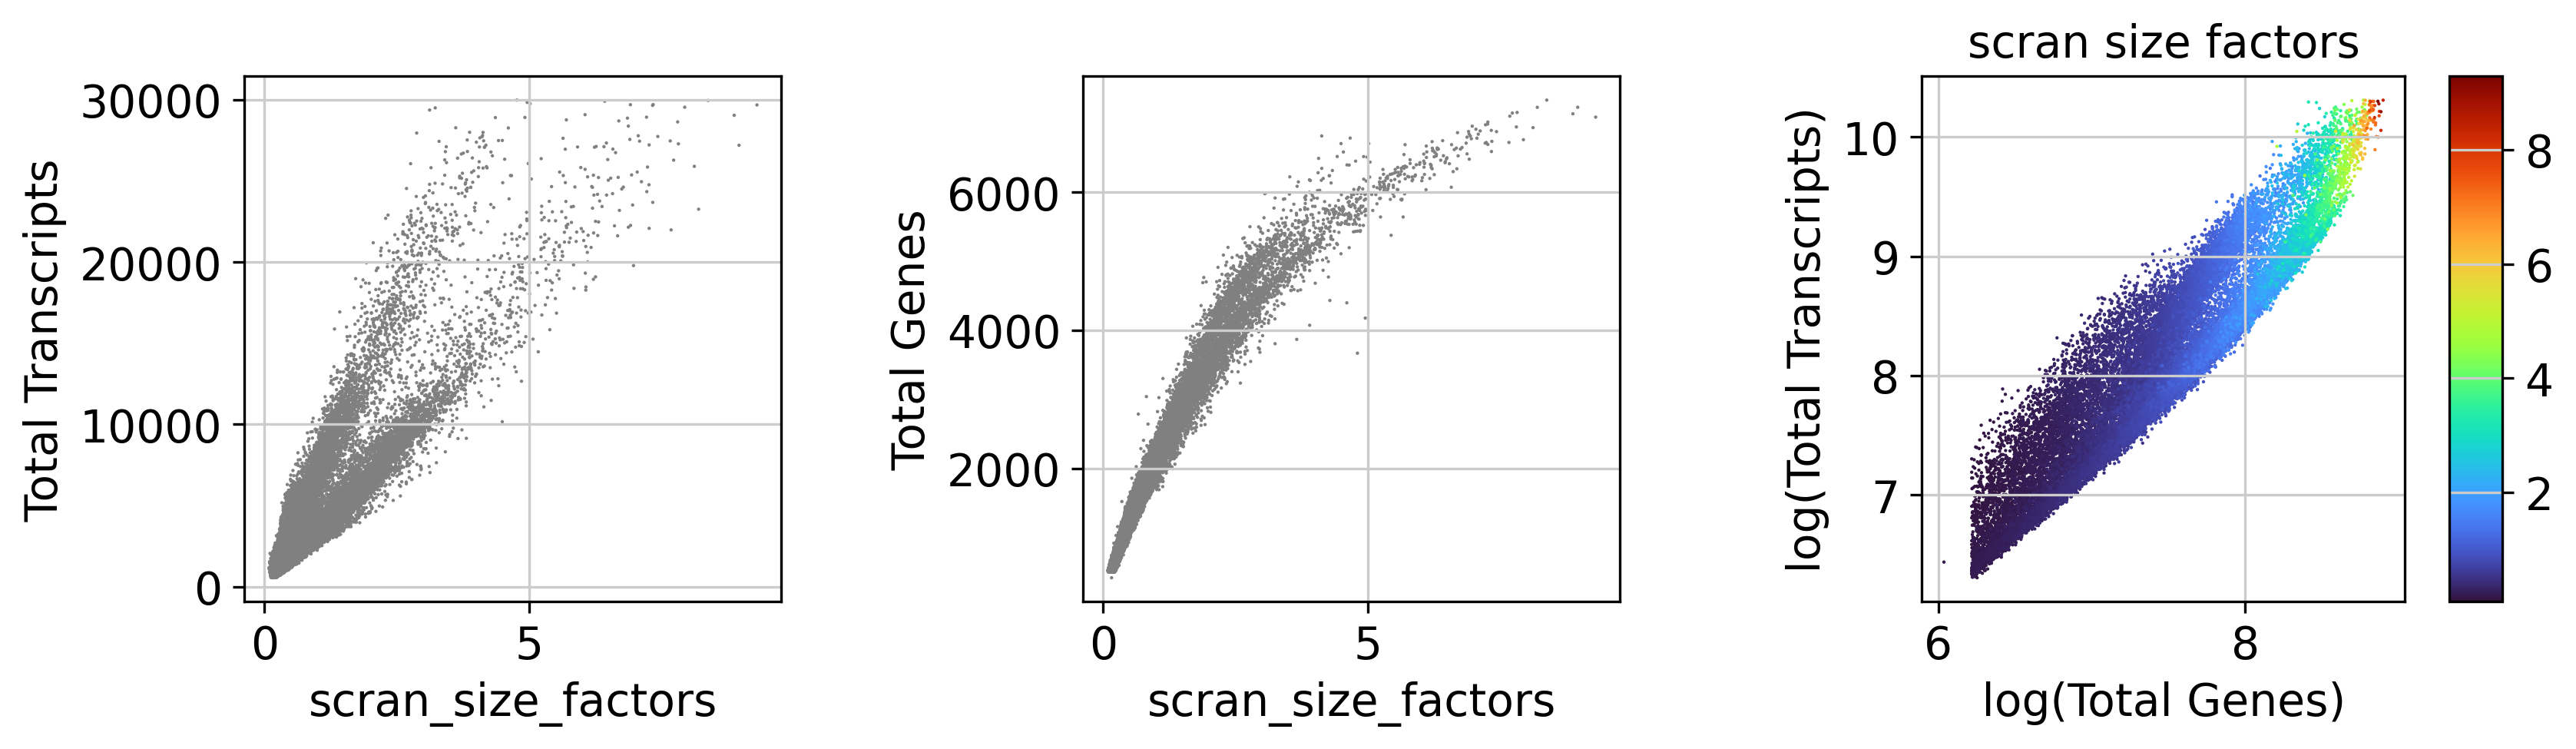

In [5]:
# comparison to size factors computed using r-scran::computeSumeFactors

def make_plots(adata):
    import matplotlib.pyplot as plt
    from matplotlib import gridspec
    from matplotlib.cm import ScalarMappable

    fig = plt.figure(figsize=(14, 3))
    gs = gridspec.GridSpec(1, 4, width_ratios=[10, 10, 9, 1])

    adata.obs[' Total Transcripts '] = adata.X.sum(1)
    adata.obs[' Total Genes '] = (adata.X > 0).sum(1)
    adata.obs[' log(Total Transcripts) '] = np.log(adata.X.sum(1))
    adata.obs[' log(Total Genes) '] = np.log((adata.X > 0).sum(1))

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    cax = plt.subplot(gs[3])
    p1 = sc.pl.scatter(adata, x='scran_size_factors', y=' Total Transcripts ', show=False, ax=ax1)
    p2 = sc.pl.scatter(adata, x='scran_size_factors', y=' Total Genes ', show=False, ax=ax2)
    p3 = sc.pl.scatter(adata, x=' log(Total Genes) ', y=' log(Total Transcripts) ', 
                    color='scran_size_factors', color_map='turbo', show=False, ax=ax3)

    del adata.obs[' Total Transcripts ']
    del adata.obs[' Total Genes ']
    del adata.obs[' log(Total Transcripts) ']
    del adata.obs[' log(Total Genes) ']

    cmap = plt.get_cmap('turbo')
    norm = plt.Normalize(vmin=p3.collections[0].get_array().min(), vmax=p3.collections[0].get_array().max())
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.subplots_adjust(wspace=0.75)
    plt.colorbar(sm, cax=cax)
    p3.collections[0].colorbar.remove()
    cax_pos = cax.get_position()
    cax.set_position([cax_pos.x0 - 0.08, cax_pos.y0, cax_pos.width, cax_pos.height])
    
make_plots(adata)